# Setup

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *
from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

In [3]:
# for pretty printed debugging
from IPython.core.debugger import set_trace

# Data

In [4]:
PATH = Path('data/pascal')
list(PATH.iterdir())

[PosixPath('data/pascal/pascal_val2007.json'),
 PosixPath('data/pascal/VOCdevkit'),
 PosixPath('data/pascal/pascal_train2012.json'),
 PosixPath('data/pascal/pascal_test2007.json'),
 PosixPath('data/pascal/VOCtrainval_06-Nov-2007.tar'),
 PosixPath('data/pascal/models'),
 PosixPath('data/pascal/PASCAL_VOC.zip'),
 PosixPath('data/pascal/pascal_train2007.json'),
 PosixPath('data/pascal/tmp'),
 PosixPath('data/pascal/pascal_val2012.json')]

## create a dictionary of training annotations: {image_id: [ ([bb coordinates], cat_id)]}

In [64]:
trn_j = json.load((PATH/'pascal_train2007.json').open())

In [65]:
trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [66]:
imgs,annos,cats = trn_j['images'],trn_j['annotations'],trn_j['categories']

In [67]:
cats = {o['id']: o['name'] for o in cats}
trn_fns = {o['id']: o['file_name'] for o in imgs}
trn_ids = [o['id'] for o in imgs]

In [21]:
# VOC: left, top, right, bottom
# BB:  top, left, height, width
def hw_bb(arr): return np.array([arr[1], arr[0], arr[3]+arr[1]-1, arr[2]+arr[0]-1])
def bb_hw(arr): return np.array([arr[1], arr[0], arr[3]-arr[1]+1, arr[2]-arr[0]+1])

In [10]:
# verify
bb = hw_bb(annos[0]['bbox'])
annos[0]['bbox'] == bb_hw(bb)

array([ True,  True,  True,  True], dtype=bool)

In [103]:
i = annos[0]

In [105]:
bb = hw_bb(i['bbox']); bb

[96, 155, 269, 350]

In [11]:
#trn_annos = collections.defaultdict(lambda: [])
trn_annos = collections.defaultdict(lambda: [])
for i in annos:
    if not i['ignore']:
        bb = hw_bb(i['bbox'])
        cat = cats[i['category_id']]
        trn_annos[i['image_id']].append((bb, cat))

### image paths

In [62]:
list(PATH.iterdir())

[PosixPath('data/pascal/pascal_val2007.json'),
 PosixPath('data/pascal/VOCdevkit'),
 PosixPath('data/pascal/pascal_train2012.json'),
 PosixPath('data/pascal/pascal_test2007.json'),
 PosixPath('data/pascal/VOCtrainval_06-Nov-2007.tar'),
 PosixPath('data/pascal/PASCAL_VOC.zip'),
 PosixPath('data/pascal/pascal_train2007.json'),
 PosixPath('data/pascal/pascal_val2012.json')]

In [68]:
list((PATH/'VOCdevkit'/'VOC2007'/'JPEGImages').iterdir())

[PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/003301.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/006279.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/008254.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/007167.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/000608.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/007601.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/001270.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/002779.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/005016.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/008526.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/007615.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/009638.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/005764.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/008268.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/004452.jp

In [67]:
imgs

[{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500},
 {'file_name': '000017.jpg', 'height': 364, 'id': 17, 'width': 480},
 {'file_name': '000023.jpg', 'height': 500, 'id': 23, 'width': 334},
 {'file_name': '000026.jpg', 'height': 333, 'id': 26, 'width': 500},
 {'file_name': '000032.jpg', 'height': 281, 'id': 32, 'width': 500},
 {'file_name': '000033.jpg', 'height': 366, 'id': 33, 'width': 500},
 {'file_name': '000034.jpg', 'height': 500, 'id': 34, 'width': 360},
 {'file_name': '000035.jpg', 'height': 375, 'id': 35, 'width': 500},
 {'file_name': '000036.jpg', 'height': 500, 'id': 36, 'width': 332},
 {'file_name': '000042.jpg', 'height': 335, 'id': 42, 'width': 500},
 {'file_name': '000044.jpg', 'height': 333, 'id': 44, 'width': 500},
 {'file_name': '000047.jpg', 'height': 333, 'id': 47, 'width': 500},
 {'file_name': '000048.jpg', 'height': 500, 'id': 48, 'width': 375},
 {'file_name': '000061.jpg', 'height': 333, 'id': 61, 'width': 500},
 {'file_name': '000064.jpg', 'heig

In [9]:
jpegs = 'VOCdevkit/VOC2007/JPEGImages'
img_path = PATH/jpegs
#list(img_path.iterdir())

In [13]:
idx = 17
im = open_image(img_path/trn_fns[idx])
im_anno = trn_annos[idx]
im_anno

[(array([ 61, 184, 198, 278]), 'person'),
 (array([ 77,  89, 335, 402]), 'horse')]

In [23]:
def show_image(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [24]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(linewidth=lw, foreground='black'), patheffects.Normal()])

In [25]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [26]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt, verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

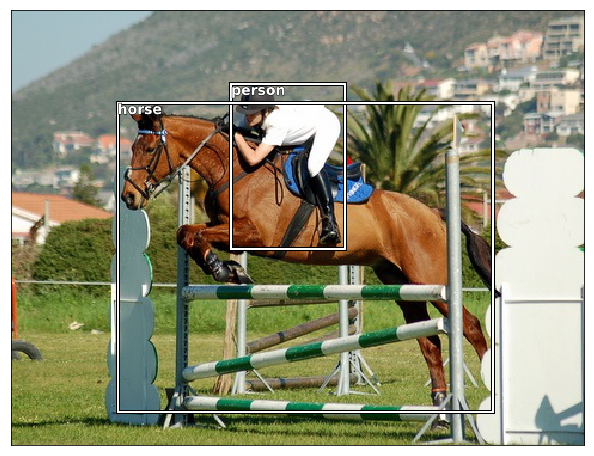

In [18]:
def draw_image(im, annotation):
    ax = show_image(im, figsize=(16,8))
    for bb,cat in annotation:
        bb = bb_hw(bb)
        draw_rect(ax, bb)
        draw_text(ax, bb[:2], cat)
        
draw_image(im, im_anno)

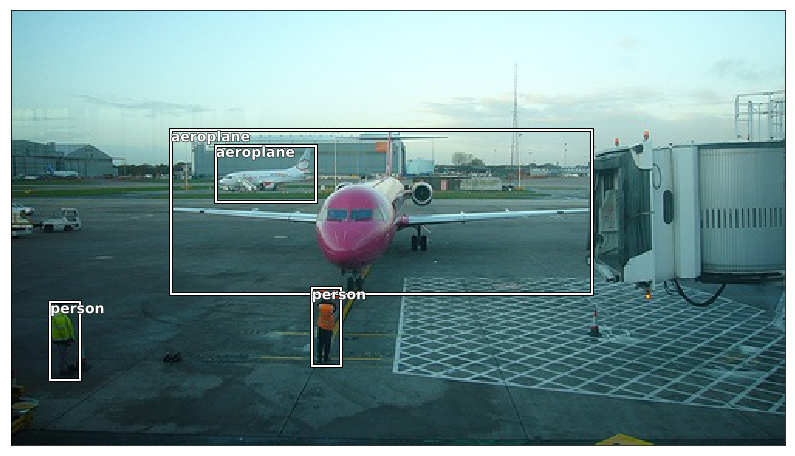

In [19]:
def draw_idx(idx):
    im = open_image(img_path/trn_fns[idx])
    im_anno = trn_annos[idx]
    draw_image(im, im_anno)

draw_idx(32)

# Classifier (largest item only)

In [20]:
def largest_box(annos):
    # anno: array of tuples
    b = sorted(annos, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)  # sorted iterates through array
    if b: 
        return b[0]
    else:
        return b

In [21]:
trn_annos_sorted = {k: largest_box(v) for k,v in trn_annos.items()}

In [23]:
trn_annos_sorted

{12: (array([ 96, 155, 269, 350]), 'car'),
 17: (array([ 77,  89, 335, 402]), 'horse'),
 23: (array([  1,   2, 461, 242]), 'person'),
 26: (array([124,  89, 211, 336]), 'car'),
 32: (array([ 77, 103, 182, 374]), 'aeroplane'),
 33: (array([106,   8, 262, 498]), 'aeroplane'),
 34: (array([166, 115, 399, 359]), 'train'),
 35: (array([ 97, 217, 317, 464]), 'person'),
 36: (array([ 78,  26, 343, 318]), 'dog'),
 42: (array([ 31, 262, 294, 499]), 'train'),
 44: (array([  0,   0, 329, 369]), 'chair'),
 47: (array([  0,  14, 311, 458]), 'car'),
 48: (array([  0,   1, 499, 301]), 'person'),
 61: (array([ 10, 273, 278, 436]), 'boat'),
 64: (array([ 22,   0, 499, 450]), 'bird'),
 66: (array([181, 241, 258, 273]), 'person'),
 73: (array([142, 120, 459, 374]), 'pottedplant'),
 77: (array([  0,   1, 332, 305]), 'cat'),
 78: (array([ 74,  14, 411, 474]), 'dog'),
 83: (array([ 32, 108, 308, 446]), 'car'),
 89: (array([ 50,  21, 290, 316]), 'chair'),
 91: (array([240, 124, 283, 194]), 'car'),
 104: (arr

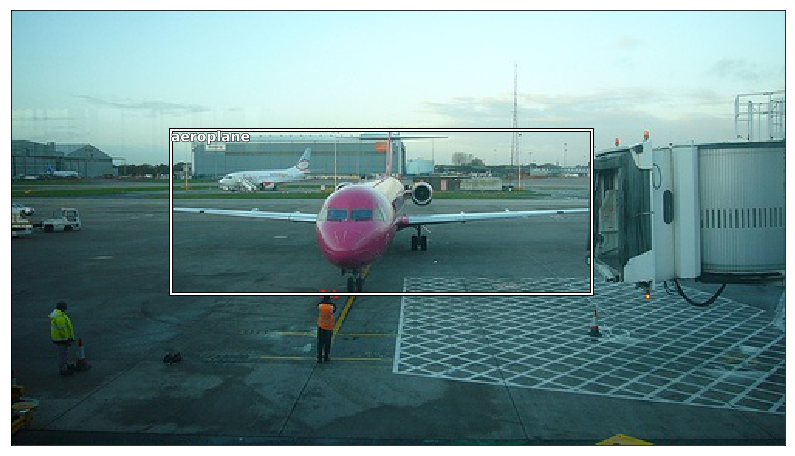

In [22]:
def draw_idx_sorted(idx):
    box,cat = trn_annos_sorted[idx]
    im = open_image(img_path/trn_fns[idx])
    ax = show_image(im, figsize=(16,8))
    b = bb_hw(box)
    draw_rect(ax, b)
    draw_text(ax, b[:2], cat)
    
draw_idx_sorted(32)

## Save as CSV

In [89]:
df = pd.DataFrame({'filename': [trn_fns[o] for o in trn_ids], 'category': [trn_annos_sorted[i][1] for i in trn_ids]}, columns=['filename', 'category'])
df

filename     category
0     000012.jpg          car
1     000017.jpg        horse
2     000023.jpg       person
3     000026.jpg          car
4     000032.jpg    aeroplane
5     000033.jpg    aeroplane
6     000034.jpg        train
7     000035.jpg       person
8     000036.jpg          dog
9     000042.jpg        train
10    000044.jpg        chair
11    000047.jpg          car
12    000048.jpg       person
13    000061.jpg         boat
14    000064.jpg         bird
15    000066.jpg       person
16    000073.jpg  pottedplant
17    000077.jpg          cat
18    000078.jpg          dog
19    000083.jpg          car
20    000089.jpg        chair
21    000091.jpg          car
22    000104.jpg       person
23    000112.jpg          dog
24    000122.jpg          cat
25    000129.jpg       person
26    000133.jpg       person
27    000134.jpg          car
28    000138.jpg       person
29    000140.jpg         sofa
...          ...          ...
2471  009851.jpg        horse
2472  009852.jpg          cat
2473  009855.jpg        train
2474  009859.jpg       person
2475  009860.jpg        train
2476  009867.jpg    tvmonitor
2477  009868.jpg       person
2478  009869.jpg       person
2479  009872.jpg        chair
2480  009874.jpg        horse
2481  009877.jpg       person
2482  009878.jpg         sofa
2483  009879.jpg          car
2484  009882.jpg       person
2485  009884.jpg  pottedplant
2486  009887.jpg  pottedplant
2487  009896.jpg          cat
2488  009904.jpg          car
2489  009911.jpg    aeroplane
2490  009918.jpg       person
2491  009920.jpg          car
2492  009926.jpg       person
2493  009938.jpg    motorbike
2494  009940.jpg         bird
2495  009942.jpg       person
2496  009944.jpg    motorbike
2497  009945.jpg        sheep
2498  009949.jpg       person
2499  009959.jpg          car
2500  009961.jpg          dog

[2501 rows x 2 columns]

In [94]:
!ls {PATH}

PASCAL_VOC.zip              pascal_train2012.json
VOCdevkit                   pascal_val2007.json
VOCtrainval_06-Nov-2007.tar pascal_val2012.json
pascal_test2007.json        tmp
pascal_train2007.json


In [39]:
os.makedirs(PATH/'tmp', exist_ok=True)
Cat_CSV = PATH/'tmp/largest.csv'

In [96]:
df.to_csv(Cat_CSV, index=False)

## Learn

In [40]:
f = resnet34
sz = 224
bs = 64

In [45]:
tfms = tfms_from_model(f,sz,aug_tfms=transforms_side_on,crop_type=CropType.NO)
md_cat = ImageClassifierData.from_csv(PATH, jpegs, Cat_CSV, bs=bs, tfms=tfms)

In [46]:
x,y = next(iter(md_cat.trn_ds))

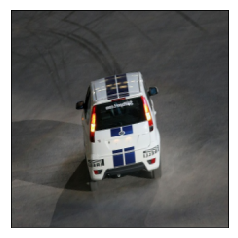

In [47]:
show_image(md_cat.trn_ds.denorm(to_np(x))[0])

In [18]:
learn = ConvLearner.pretrained(f, md_cat, metrics=[accuracy])
learn.opt_fn = optim.Adam

/home/paperspace/fastai/courses/dl2/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/paperspace/fastai/courses/dl2/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [19]:
learn.lr_find()

 91%|█████████ | 29/32 [00:08<00:00,  3.31it/s, loss=10.3]


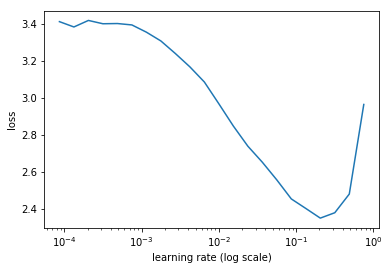

In [20]:
learn.sched.plot(n_skip=5, n_skip_end=1)

In [21]:
lr = 2e-2

In [22]:
learn.fit(lr, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                 
    0      1.24314    0.679355   0.806     



[0.6793548445701599, 0.8059999980926513]

In [26]:
lrs = np.array([2e-5, 2e-4, lr])

In [27]:
learn.freeze_to(-2)

 84%|████████▍ | 27/32 [00:17<00:03,  1.52it/s, loss=3.67] 

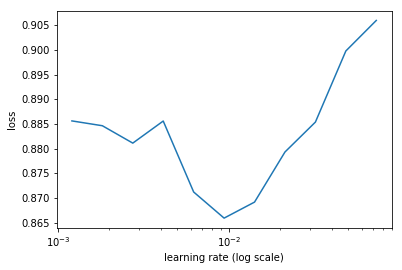

In [29]:
learn.lr_find(lrs/1000)
learn.sched.plot()

In [30]:
learn.fit(lrs/5, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.81257    0.620778   0.818     


[0.6207784740924835, 0.8179999976158142]

In [31]:
learn.unfreeze()

In [32]:
learn.fit(lrs/5, 1, cycle_len=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.650209   0.639661   0.818     
    1      0.441847   0.590753   0.832                     


[0.5907529969215393, 0.8320000009536743]

In [33]:
learn.fit(lrs/5, 1, cycle_len=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.371324   0.588689   0.834     
    1      0.267601   0.57447    0.834                     


[0.5744700667858124, 0.8340000009536743]

In [34]:
learn.save('largest_object')

In [35]:
x,y = next(iter(md_cat.val_dl))

In [36]:
pred = predict_batch(learn.model, x)  # torch.Size([64, 20])

In [39]:
probs = F.softmax(pred, -1)

In [43]:
x,preds = to_np(x), to_np(probs)
preds = np.argmax(preds, -1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


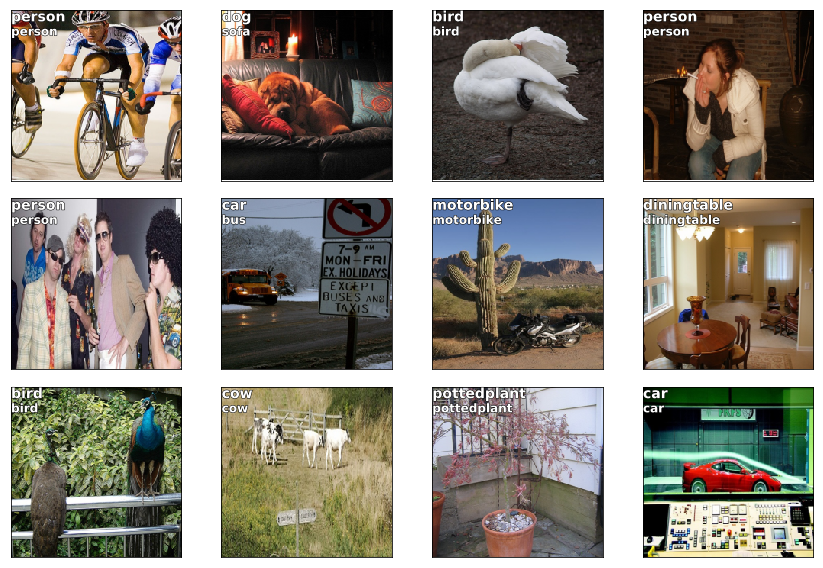

In [51]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima = md_cat.val_ds.denorm(x)[i]
    b = md_cat.classes[preds[i]]
    ax = show_image(ima, ax=ax)
    draw_text(ax, (0,0), b)
    y_act = md_cat.classes[y[i]]
    draw_text(ax, (0,20), y_act, sz=12)
plt.tight_layout()

# Bounding Box (largest item)
** simply a regression w/ 4 outputs **

## create CSV

In [45]:
# 1836: (array([ 80,   1, 374, 461]), 'sofa'),
bbs = [trn_annos_sorted[b][0].tolist() for b in trn_ids]
box = [' '.join([str(i) for i in li]) for li in bbs]

In [46]:
df = pd.DataFrame({'filename': [trn_fns[o] for o in trn_ids], 'box': box}, columns=['filename', 'box'])
df.head()

filename             box
0  000012.jpg  96 155 269 350
1  000017.jpg   77 89 335 402
2  000023.jpg     1 2 461 242
3  000026.jpg  124 89 211 336
4  000032.jpg  77 103 182 374

In [33]:
Box_CSV = PATH/'tmp/largest_box.csv'
df.to_csv(Box_CSV, index=False)

## coordinate transforms

In [6]:
f = resnet34
sz = 224
bs = 64

In [36]:
# when doing augmentation; we need to also transform the dependent variable (bounding boxes) hence tfm_y
# TfmType.COORD 
tfm_y = TfmType.COORD
augs = [RandomFlip(tfm_y=tfm_y), RandomRotate(10, tfm_y=tfm_y), RandomLighting(0.1, 0.1, tfm_y=tfm_y)]

In [37]:
tfms = tfms_from_model(f, sz, aug_tfms=augs, tfm_y=tfm_y, crop_type=CropType.NO)
md_box = ImageClassifierData.from_csv(PATH, jpegs, Box_CSV, bs=bs, tfms=tfms, continuous=True)

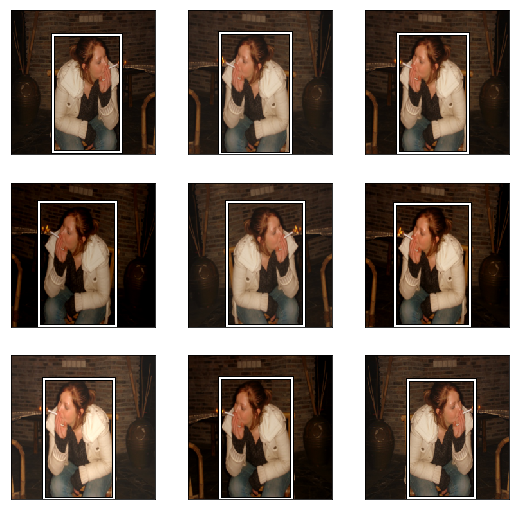

In [38]:
idx=3
# axes: numpy matrix (3,3) of axes objects in figure
fig,axes = plt.subplots(3,3, figsize=(9,9))
for ax in axes.flat:
    x,y = next(iter(md_box.aug_dl))
    im = md_box.val_ds.denorm(to_np(x))[idx]
    b = bb_hw(to_np(y[idx]))
    show_image(im, ax=ax)
    draw_rect(ax, b)

## Custom head

fastai let's you use a `custom_head` to add your own module on top of a convnet, instead of the adaptive pooling and fully connected net which is added by default. In this case, we don't want to do any pooling, since we need to know the activations of each grid cell.

The final layer has 4 activations, one per bounding box coordinate. Our target is continuous, not categorical, so the MSE loss function used does not do any sigmoid or softmax to the module outputs.

In [57]:
l = ConvLearner.pretrained(f, md_box)
l.summary()
# custom_head replaces 'AdaptiveMaxPool2d-123' and below
# Last Layer:
# ('BasicBlock-122',
#   OrderedDict([('input_shape', [-1, 512, 7, 7]),
#                ('output_shape', [-1, 512, 7, 7]),
#                ('nb_params', 0)])),

/Users/adamschiller/Projects/DeepLearning/fastai/courses/dl2/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', tensor(9408))])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', tensor(128))])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape

In [28]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(512*7*7,4))
learn = ConvLearner.pretrained(f,md_box,custom_head=head_reg4)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

In [59]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', tensor(9408))])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', tensor(128))])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape

## Train

In [37]:
learn.lr_find()

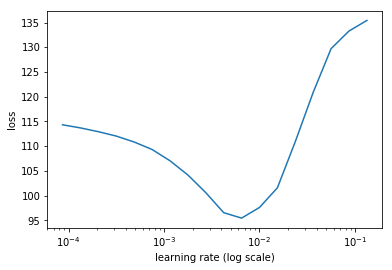

In [40]:
learn.sched.plot(5)

In [41]:
lr = 1e-3

In [42]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                            
    0      49.598161  39.411987 
    1      38.563066  30.06714                            
    2      33.267915  29.577277                           


[29.577276641845703]

In [43]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                            
    0      28.415761  28.742351 
    1      27.503188  27.417663                           
    2      26.595788  26.73892                            


[26.738919692993164]

In [44]:
lrs = np.array([lr/100, lr/10, lr])

In [45]:
learn.freeze_to(-2)

In [46]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                            
    0      24.63357   24.302566 
    1      22.772307  22.59901                            
    2      21.14112   21.397112                           


[21.397111541748046]

In [47]:
lrs = np.array([lr/1000, lr/100, lr])

In [48]:
learn.freeze_to(-3)
learn.fit(lrs, 3, cycle_len=1)

epoch      trn_loss   val_loss                            
    0      19.306675  21.36573  
    1      19.214883  21.052332                           
    2      18.857706  21.192705                           


[21.19270506286621]

In [49]:
learn.save('bbox')

In [29]:
learn.load('bbox')  # only on GPU...

FileNotFoundError: [Errno 2] No such file or directory: 'data/pascal/models/bbox.h5'

In [50]:
x,y = next(iter(md_box.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


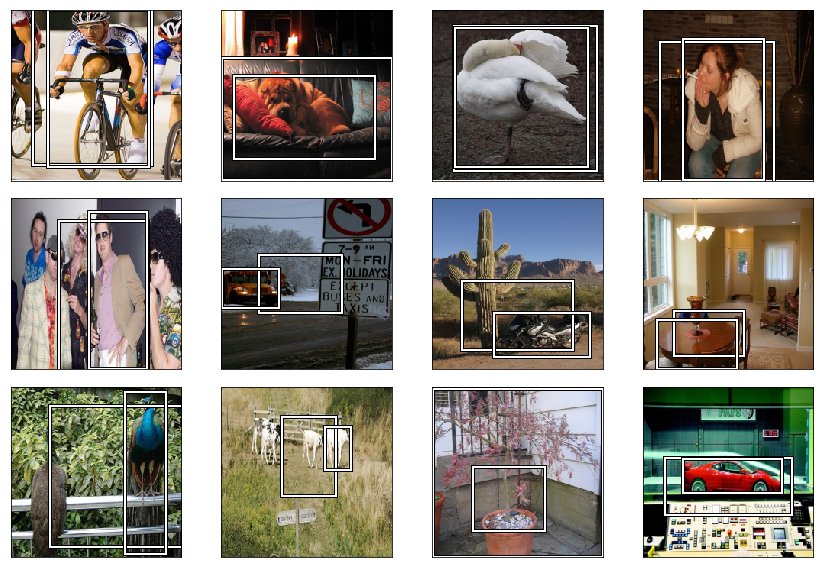

In [52]:
fig,axes = plt.subplots(3,4, figsize=(12,8))
for i,ax in enumerate(axes.flat):
    im = md_box.val_ds.denorm(to_np(x))[i]
    b = bb_hw(preds[i])
    ax = show_image(im, ax=ax)
    draw_rect(ax, b)
    b_act = bb_hw(y[i])
    draw_rect(ax, b_act)
plt.tight_layout()

# Single Object Detection (classify and bounding box of largest item)

need model data object
 - independent variables are images
 - dependent variables are tuples of box coordinates and categories

In [44]:
# already have two separate model data objects with the right info, lets combine the data loaders!
# md_box -> bounding box
# md_cat -> categories

class ConcatLblDataset(Dataset):
    # add second label to an existing dataset
    def __init__(self, ds, y2): self.ds,self.y2 = ds,y2
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [48]:
trn_ds = ConcatLblDataset(md_box.trn_ds, md_cat.trn_y)
val_ds = ConcatLblDataset(md_box.val_ds, md_cat.val_y)

In [51]:
trn_ds[0][1]

(array([  55.,   66.,  187.,  161.], dtype=float32), 6)

In [52]:
# re-use the bounding box data loader and replace w/ new datasets
md_box.trn_dl.dataset = trn_ds
md_box.val_dl.dataset = val_ds

In [53]:
# check images
x,y = next(iter(md_box.trn_dl))

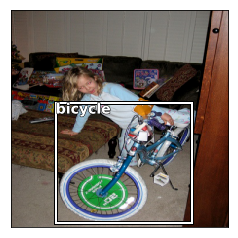

In [78]:
idx = 3
im = md_box.trn_ds.ds.denorm(to_np(x))[idx]
ax = show_image(im)
b = bb_hw(to_np(y[0][idx]))
draw_rect(ax, b)
draw_text(ax, b[:2], md_cat.classes[y[1][idx]])

## Set up model

In [ ]:
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25088,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),  # batchnorm after relu
    nn.Dropout(0.5),
    nn.Linear(256,4+len(cats)),
    # first 4 are coordinates of bounding box
    # last 20 are classes
)
models = ConvnetBuilder(f, 0, 0, 0, custom_head=head_reg4)

In [80]:
models.get_layer_groups()

[[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
  ReLU(inplace),
  MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
  Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

In [81]:
learn = ConvLearner(md_box, models)
learn.opt_fn = optim.Adam

In [83]:
def detection_loss(input, target):
    # bounding box and class
    bb_target,class_target = target
    bb_input,class_input = input[:, :4], input[:, 4:]     # first dimensions are minibatches
    
    # pass coordinate inputs through sigmoid to squish between 0 and 1 and then multiply by 224
    # helps NN get coordinates in the appropriate range for our images
    bb_input = F.sigmoid(bb_input)*224
    
    # L1 loss for bounding box coordinates
    # Cross Entropy for classes
    # loss functions are different scales hence *20 to roughly scale them the same
    return F.l1_loss(bb_input, bb_target) + F.cross_entropy(class_input, class_target)*20

def detection_l1(input,target):
    bb_input = input[:,:4]
    bb_target,_ = target
    bb_input = F.sigmoid(bb_input)*224
    return F.l1_loss(V(bb_input),V(bb_target)).data

def class_acc(input,target):
    preds = input[:,4:]
    _,target = target
    return accuracy(preds,targets)

learn.crit = detection_loss
learn.metrics = [detection_l1, class_acc]

In [ ]:
learn.lr_find()